<a href="https://colab.research.google.com/github/jghcobussen/PRA3024/blob/master/Week5_Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: ML cifar CNN

Creator:         Joyce Cobussen

Student ID:   i6170709

Information: Throughout the code, several comments starting with 'INFO' explain the workings and/or function of certain aspects of the code. I mainly did this for myself to improve my understanding of the code. This code was produced in collaboration with Mickey Gherardi, Luka Bowen, Felix Quinque & Raquel Grosman. 



In [0]:
# Some data-handling functions to download/import.
# Colaborated with: Mickey Gherardi, Luka Bowen, Felix Quinque & Raquel Grosman

# got some inspiration from :
# https://missinglink.ai/guides/keras/keras-conv2d-working-cnn-2d-convolutions-keras/
# and
# https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

#code below written/given by Jacco
"""I load some cifar"""
#impoting libraries
import numpy as np
from sklearn.model_selection import train_test_split
import os, sys


if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict



# getting the data
def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [4]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


Using TensorFlow backend.


In [5]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


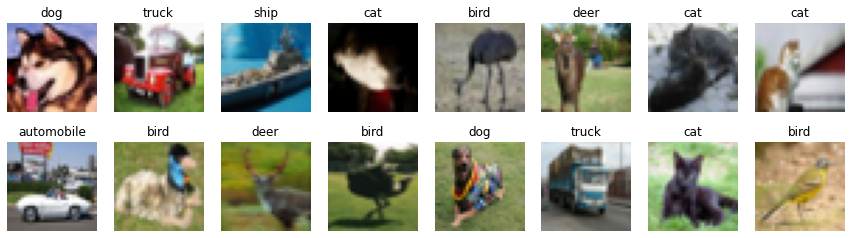

In [6]:
# Show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [0]:
# Normalize inputs
# Convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)

# INFO: one-hot encoded splits a column consisting of datapoints with different values into seperate columns. Each column belongs
# to a specific value. The datapoints that have that certain value are given a value of 1 in that column, otherwise 0. This is done
# to ensure that the program does not give priorities to data with higher values, because that is often not relevant at all and 
# may lead to biased processing (https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f).

# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [0]:
# import necessary building blocks
from keras.models import Sequential

# INFO: BatchNormalization serves to reduce covariance shift, which is the amount by which hidden unit values shift around. 
# It does so by applying a transformation to the activation of the previous layer to keep its mean close to 0 and its
# standard deviation close to 0. This regularizes the model and increases the learning rate. 
# (https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/)

# INFO: Dropout randomly drops some of the nodes of a layer. This simplifies the model and prevents it from overfitting the data.
# (https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/)

# INFO: Maxpooling is a way of downsizing the output by only taking the max output of a certain region of an image. It reduces 
# computational load and helps to prevent overfitting (https://computersciencewiki.org/index.php/Max-pooling_/_Pooling).

# INFO: A convolutional layer extracts features from an image by scanning it with a nxn sized filter. The 2D part means that the 
# input of the convolution layer is three dimensional. For example in a colored picture, the scan has to occur three times (once 
# for each color) and the operation thus moves twice from one color to the next (https://missinglink.ai/guides/tensorflow/tensorflow-conv2d-layers-practical-guide/). 

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
 
    # setting layers -- in order to get the highest accuracy rate 
    model = Sequential()

    # INFO: The Conv2D layer does ...
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization()) 
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform', padding='same'))
    model.add(BatchNormalization())
    # model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(256, activation='relu', kernel_initializer='lecun_uniform'))

    model.add(Dropout(0.2))

    # The last layer must have the same number of nodes as there are classes/catagories, in our case 10
    model.add(Dense(10, activation='softmax'))

    model.summary()
    return model

In [10]:
### changed the parameters below to perform a better training
INIT_LR = 1e-3  
BATCH_SIZE = 50
EPOCHS = 20

K.clear_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)

# INFO: an optimizor decides how the difference between predictions and actual values is used to 
# update the weights of the nodes. In this case, we use adamax (https://www.kaggle.com/residentmario/keras-optimizers)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR), 
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE, #the amount of objects it takes to run over (per iteration)
    epochs=EPOCHS, # number of iterations
    validation_data=(x_val, y_val), 
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0  

In [0]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")


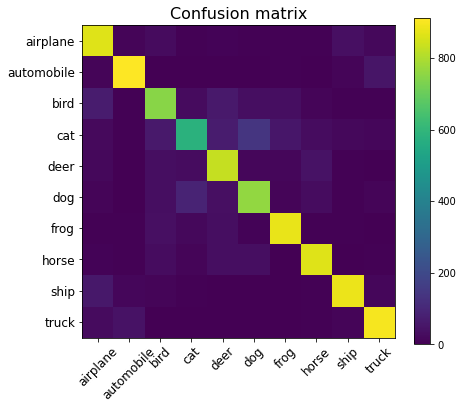

Test accuracy: 0.8244


In [12]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

The plot above shows that some of the most common mistakes are between cat and dog, bird and airplane and ship/truck and automobile. This seems reasonable, as those catagories have some similar features. For example, birds and airplanes both have wings and are often displayed against a blue/white background. Similarly, cars and trucks both have wheels and are shown on a road. 

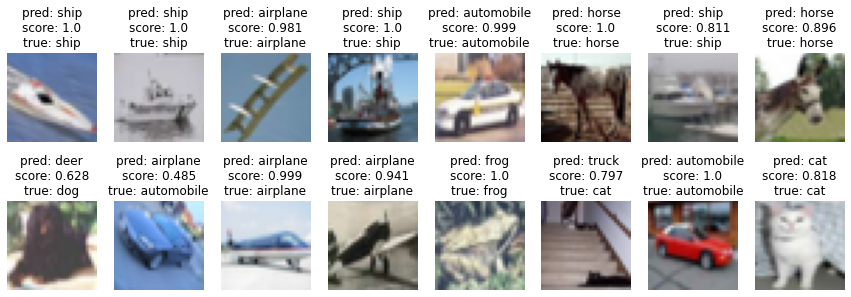

In [13]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

The images above show that the AI is doing relatively well; some of the images that it could not guess correctly are even hard to estimate to humans. 

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:

 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




In [0]:
# extra:

# what i did and worked but not perfectly... like with 67% acurracy 

   # model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network. 
    ### First, make a CNN layer with some small kernels to learn some basic features,
    # with Conv2D.
    #input is image
    #label is the lable of the image
    # Sequential.add()
    # model.add(Conv2D(64, kernel_size=3, activation=’relu’, input_shape=(28,28,1)))

    # input_shape = (32, 32, 3)
  

    # model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), # the kernal size might not be ok, check later
    #                 activation='relu',
    #                 input_shape=input_shape))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) ### Then, add a Pooling layer to pick up the relevant kernels.
    # model.add(Conv2D(64, (5, 5), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())                                 ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    # model.add(Dense(500, activation='relu'))
    # model.add(Dense(10, activation='softmax'))  ###  to learn the relevant combinations of low-level kernel features.
   # Sequential.add(Dropout) ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima

       ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.

    ### END STUDENT CODE ###
    # model.compile()
    # Ensure normalized probabilities over the 10 classes
    # model.add(Activation("softmax")) 